In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from src.data import load_categories, load_hills, load_glove_model, load_word_frequency, load_nelson

HILLS_DATA_PATH       = '../data/hills.csv'
REBA_CATEGORIES_PATH  = '../data/reba_categories.csv'
WORD_FREQ_PATH        = '../data/word_frequency.csv'
GLOVE_PATH            = '../data/glove/glove.6B.300d.txt'
NELSON_PATHS          = ['../data/nelson_a1.csv', '../data/nelson_a2.csv']

hills_csv        = load_hills(HILLS_DATA_PATH)
reba_categories  = load_categories(REBA_CATEGORIES_PATH)
word_freq        = load_word_frequency(WORD_FREQ_PATH)
nelson           = load_nelson(NELSON_PATHS, reba_categories.keys())
glove_model      = load_glove_model(GLOVE_PATH)

Loading GloVe...


400000it [00:10, 38569.03it/s]

400000 words loaded!


In [4]:
from src.data import preprocess_hills
from src.switch import adjudicate_categorization

hills = preprocess_hills(hills_csv, glove_model, reba_categories)
reba_adj = adjudicate_categorization(reba_categories, hills)

In [5]:
from src.tree import create_animal_graph

EPSILON = 0.4
G = create_animal_graph(reba_categories.keys(), glove_model, word_freq, EPSILON)

### Sub-Category Transition Figure

In [5]:
import numpy as np
from src.switch import get_category_transitions

transition_probs = get_category_transitions(hills)

states = list(transition_probs.keys())
transition_matrix = np.asarray([[transition_probs[s1][s2] for s2 in states] for s1 in states])

/var/folders/cr/z51hvhb932vbx29jw5hxd9nh0000gn/T/ipykernel_2100/99314455.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Greys', 10)


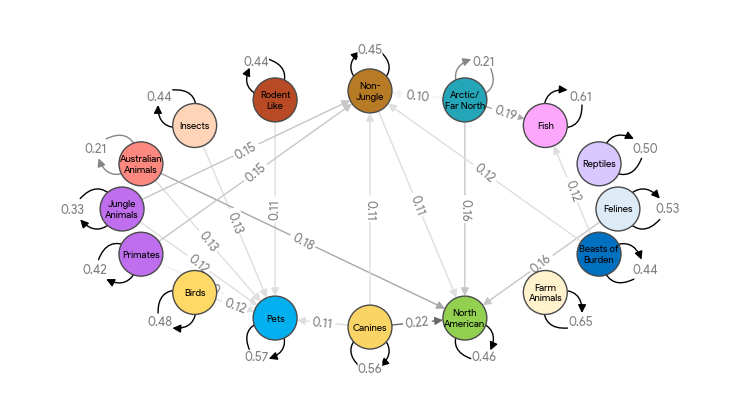

In [6]:
from src.data import REBA_CATEGORY_COLORS

import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.cm as cm

plt.rcParams['font.sans-serif'] = 'Product Sans'

DG = nx.DiGraph()

state_ordering = [
    'Felines', 'Reptiles/Amphibians', 'Fish', 'Arctic/Far North Animals', 
    'Non-Jungle Animals', 'Rodent Like', 'Insects', 'Australian Animals', 
    'Jungle Animals', 'Primates', 'Birds', 'Pets', 'Canines', 'North American', 
    'Farm Animals', 'Beasts of Burden',
]

for state in state_ordering:
    DG.add_node(state)

cmap = cm.get_cmap('Greys', 10)

for i in range(len(states)):
    for j in range(len(states)):
        weight = transition_matrix[i, j]
        if weight > 0.1 and states[i] != states[j]:
            DG.add_edge(states[i], states[j], weight=weight, color=cmap(int((weight-0.05) * 35)))

pos = nx.circular_layout(DG)
edge_labels = {(i, j): f'{weight:.2f}' for i, j, weight in DG.edges(data='weight')}
edge_colors = {(i, j): data['color'] for i, j, data in DG.edges(data=True)}
color_map = [REBA_CATEGORY_COLORS[node] for node in DG]

node_labels = {node: node.replace(' ', '\n').replace('/', '/\n') for node in DG}
node_labels['Beasts of Burden'] = 'Beasts of\nBurden'
node_labels['Arctic/Far North Animals'] = 'Arctic/\nFar North'
node_labels['Non-Jungle Animals'] = 'Non-\nJungle'
node_labels['Reptiles/Amphibians'] = 'Reptiles'

plt.figure(figsize=(7.2, 4))
nx.draw(DG, pos, node_size=1000, node_color=color_map, arrows=True, arrowsize=12, edgecolors='#4a4a4a', 
        edge_color=[edge_colors[edge] for edge in DG.edges()])
nx.draw_networkx_labels(DG, pos, labels=node_labels, font_size=7, font_color='black')
nx.draw_networkx_edge_labels(DG, pos, edge_labels=edge_labels, font_color='grey', font_size=9, rotate=True,
                             bbox=dict(boxstyle="round, pad=0.2", ec="none", fc=(1,1,1)))

centroid = np.mean(np.stack(list(pos.values())), axis=0)

# Draw transition lines to the same node
DG.clear_edges()
for i in range(len(states)):
    for j in range(len(states)):
        weight = transition_matrix[i, j]
        if states[i] == states[j]:
            mid = f'{states[i]}_transition'
            DG.add_node(mid)
            pos[mid] = (pos[states[i]] - centroid) * np.asarray([1.2, 1.4])
            DG.add_edge(states[i], mid, weight=weight, color=cmap(int((weight-0.05) * 35)))
            DG.add_edge(mid, states[j], weight=weight, color=cmap(int((weight-0.05) * 35)))
            DG.add_edge(states[i], mid, weight=weight, color=cmap(int((weight-0.05) * 35)))
            DG.add_edge(mid, states[j], weight=weight, color=cmap(int((weight-0.05) * 35)))
edge_labels = {(i, j): f'{weight:.2f}' for i, j, weight in DG.edges(data='weight')}
edge_colors = {(i, j): data['color'] for i, j, data in DG.edges(data=True)}
nx.draw(DG, pos, node_size=350, arrows=True, arrowsize=12, edgecolors=(0, 0, 0, 0), node_color=[(0, 0, 0, 0) for node in DG],
        edge_color=[(edge_colors[edge]) for edge in DG.edges()], arrowstyle='<|-', connectionstyle="arc3,rad=0.8")

# Draw transition probs to the same node
DG.clear_edges()
for i in range(len(states)):
    for j in range(len(states)):
        weight = transition_matrix[i, j]
        if states[i] == states[j]:
            DG.add_edge(states[i], states[j], weight=weight, color=cmap(int((weight-0.05) * 35)))
edge_labels = {(i, j): f'{weight:.2f}' for i, j, weight in DG.edges(data='weight')}
label_pos = {}
for k in pos.keys():
    label_pos[k] = (pos[k] - centroid) * np.asarray([1.2, 1.35])
nx.draw_networkx_edge_labels(DG, label_pos, edge_labels=edge_labels, font_color='grey', font_size=9, rotate=True,
                             bbox=dict(boxstyle="round, pad=0", ec="none", fc=(1,1,1)))

out_filename = "img/category_transitions.pdf"
plt.savefig(out_filename, format="pdf", bbox_inches='tight', pad_inches=-0.3, dpi=300)

plt.show()

### Evaluation with BLEU

In [7]:
import statistics
from nltk.translate.bleu_score import sentence_bleu

resps = [r['response'] for r in hills]

human_scores = []
for i, r in enumerate(resps):
    human_scores += [sentence_bleu(resps[:i] + resps[i+1:], r, weights=(0.5, 0.5, 0.5))]

statistics.mean(human_scores)

0.22260201194856558

In [8]:
from src.search import cue_switch_step, graph_traversal

def traversal_func(graph, sequence, current_node):
        return cue_switch_step(graph, current_node, 1, 1)

scores = []
for i in range(1000):
    walk = graph_traversal(G, traversal_func, traversal_method='sample')
    scores += [sentence_bleu(resps, walk[1:], weights=(0.5, 0.5, 0.5))]
    
statistics.mean(scores)

/Users/dhei/miniconda3/envs/typical/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.06417822314783

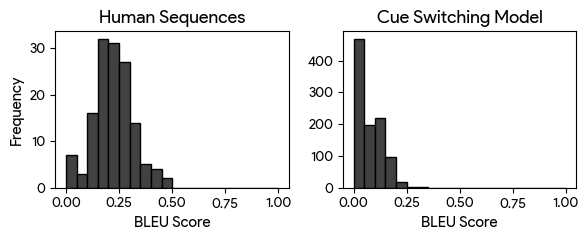

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(6, 2.5), sharex=True)

axs[0].hist(human_scores, bins=20, range=(0, 1), edgecolor='black', color='#414141')
axs[1].hist(scores, bins=20, range=(0, 1), edgecolor='black', color='#414141')

axs[0].set_title('Human Sequences', fontsize=13)
axs[1].set_title("Cue Switching Model", fontsize=13)
axs[0].set_ylabel('Frequency', fontsize=11)
axs[0].set_xlabel('BLEU Score', fontsize=11)
axs[1].set_xlabel('BLEU Score', fontsize=11)

plt.tight_layout()
out_filename = "img/bleu_dist.pdf"
plt.savefig(out_filename, format="pdf", bbox_inches='tight', pad_inches=0.0, dpi=300)
plt.show()